## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Embedding, Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
import string
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from nltk.tokenize import word_tokenize
import nltk

import warnings
warnings.filterwarnings('ignore')


import tensorflow as tf

## Importing Data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/MergedSenti.csv')

In [4]:
df.head()

,neg,neu,pos,compound,Post,Class
0,0.163,0.658,0.178,0.1406,attempted yesterday i had an exit yesterday an...,SuicidalThoughts
1,0.000,0.892,0.108,0.4404,my bf of years just tried to hang himself las...,SuicidalThoughts
2,0.141,0.665,0.194,0.8683,he gave up because of me we have shared many ...,SuicidalThoughts
3,0.045,0.873,0.081,0.2960,running out of options does anyone have any co...,SuicidalThoughts
4,0.299,0.588,0.113,-0.9927,my life is shit i feel like shit i hate mysel...,SuicidalThoughts


In [5]:
df['Class'].value_counts()

Exercise            14621
SuicidalThoughts    13915
Depression          13712
Happy                9659
Name: Class, dtype: int64

## Changing the classes of Depression and SuicidalThoughts to 1 and Happy and Exercise to 0

In [6]:
df.isnull().sum()

neg          0
neu          0
pos          0
compound     0
Post        86
Class        0
dtype: int64

In [7]:
df = df.dropna()

In [8]:
df.isnull().sum()

neg         0
neu         0
pos         0
compound    0
Post        0
Class       0
dtype: int64

In [9]:
df['Class'].value_counts()

Exercise            14563
SuicidalThoughts    13915
Depression          13712
Happy                9631
Name: Class, dtype: int64

In [10]:
# creating a 0 and 1s class
df['Class'] = df['Class'].replace({'SuicidalThoughts': 1,'Depression': 1, 'Happy': 0, 'Exercise': 0})

In [11]:
df['Class'].value_counts()

1    27627
0    24194
Name: Class, dtype: int64

In [12]:
# Finding the longest text which will later be used to ensure that all texts have the same length by adding padding
lengths = df['Post'].apply(lambda x: len(x.split()))
max_len = lengths.max()
print(max_len)
print(lengths.argmax())
print(df['Post'].iloc[lengths.argmax()])

4363
21021
any advice would be appreciated  i don t entirely know why i felt like i should write this i think it started when my therapist asked me if i d ever found someone else who seems to be going through the same thing i am and well i realized that maybe i hadn t spent enough time trying to find others who see things similarly i apologize in advance for how long and rambly this is and i am very appreciative to anyone who attempts to make it all the way through i tried to provide some overall structure and give enough background to explain why i feel the way i do now but it may come off as a bit more stream of consciousness than narrative style   note i live in the united states names and some specific details have been changed to preserve anonymity   amp x  b   i don t think i had a particularly happy childhood but there was also nothing extraordinarily bad about it i always had food clothes a house we weren t rich but we never really had money troubles either while i think there 

### Splitting data into X and y sets


In [13]:
X = df['Post']
y = df['Class']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [15]:
X_train.shape, y_train.shape

((38865,), (38865,))

In [16]:
X_test.shape, y_test.shape

((12956,), (12956,))

### Creating a Corpus

In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
# create a corpus of words
def create_corpus_tk(df):
    corpus = []
    for text in df['Post']:
      try:
          words = word_tokenize(text)
          corpus.append(words)
      except:
        pass
    return corpus

In [19]:
corpus = create_corpus_tk(df)

In [20]:
print(corpus[10])

['i', 'm', 'near', 'relapse', 'bc', 'of', 'all', 'the', 'pressure', 'i', 'have', 'and', 'worse', 'i', 'got', 'cucked', 'by', 'my', 'friend', 'and', 'the', 'girl', 'thought', 'i', 'faked', 'liking', 'her', 'i', 'feel', 'shit', 'beyond', 'shit', 'the', 'pressure', 'from', 'life', 'uni', 'exams', 'and', 'now', 'the', 'girl', 'who', 'i', 'really', 'liked', 'and', 'was', 'obvious', 'i', 'liked', 'her', 'who', 'talked', 'how', 'she', 'wanted', 'to', 'date', 'me', 'to', 'which', 'i', 'also', 'said', 'yes', 'was', 'stolen', 'from', 'me', 'by', 'someone', 'i', 'called', 'a', 'friend', 'and', 'to', 'them', 'i', 'was', 'obvious', 'i', 'liked', 'her', 'they', 'knew', 'about', 'my', 'trauma', 'from', 'past', 'relationships', 'and', 'yet', 'they', 'fucking', 'did', 'this', 'worse', 'of', 'all', 'they', 'added', 'me', 'in', 'a', 'group', 'to', 'tell', 'me', 'they', 'were', 'a', 'couple', 'in', 'the', 'middle', 'of', 'a', 'colab', 'they', 'didn', 't', 'know', 'that', 'it', 'was', 'an', 'impromptu', 'o

In [21]:
num_words = len(corpus)
num_words

51821

### Tokenizing the words

In [22]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index

In [23]:
# words_to_index

### Creating a dictionary that maps the words to their word embeddings

In [24]:
embedding_dict = {}

def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      embedding_dict[curr_word] = np.array(w_line[1:], dtype=np.float64)

  return embedding_dict

In [25]:
# Reading in the pretrained glove model which was downloaded from https://nlp.stanford.edu/projects/glove/
word_to_vec_map = read_glove_vector('/content/drive/MyDrive/glove.twitter.27B.100d.txt')


In [26]:
# word_to_vec_map

In [27]:
word_index = tokenizer.word_index
print("Number of unique words:", len(word_index))

Number of unique words: 40114


### Defining an Embedding Matrix

In [28]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in word_index.items():
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec

In [29]:
embedding_matrix.shape

(40115, 100)

## Instantiating a Model

In [30]:
# the model contains a combination of lstm and cnn layers
model = Sequential()
model.add(Embedding(
    num_words,
    100,
    embeddings_initializer=Constant(embedding_matrix),
    input_length = max_len,
    trainable=False
))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences=True)) # return_sequences so that it can pass the output to the next layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
# tokenizing and padding the data so they can be easily used by the model

X_train_indices = tokenizer.texts_to_sequences(X_train)
X_train_indices = pad_sequences(X_train_indices, maxlen=max_len, padding='post')

X_test_indices = tokenizer.texts_to_sequences(X_test)
X_test_indices = pad_sequences(X_test_indices, maxlen=max_len, padding='post')

## Fitting the Model

In [32]:
history = model.fit(X_train_indices, y_train,
                    validation_data=(X_test_indices, y_test),
                    batch_size=32, epochs=10)

Epoch 1/10
1215/1215 [==============================] - 188s 143ms/step - loss: 0.1452 - accuracy: 0.9532 - val_loss: 0.0792 - val_accuracy: 0.9849
Epoch 2/10
1215/1215 [==============================] - 174s 143ms/step - loss: 0.0994 - accuracy: 0.9784 - val_loss: 0.0569 - val_accuracy: 0.9887
Epoch 3/10
1215/1215 [==============================] - 174s 143ms/step - loss: 0.1003 - accuracy: 0.9772 - val_loss: 0.1213 - val_accuracy: 0.9574
Epoch 4/10
1215/1215 [==============================] - 174s 143ms/step - loss: 0.0579 - accuracy: 0.9829 - val_loss: 0.0350 - val_accuracy: 0.9895
Epoch 5/10
1215/1215 [==============================] - 174s 143ms/step - loss: 0.0403 - accuracy: 0.9855 - val_loss: 0.0426 - val_accuracy: 0.9880
Epoch 6/10
1215/1215 [==============================] - 174s 143ms/step - loss: 0.0303 - accuracy: 0.9904 - val_loss: 0.0234 - val_accuracy: 0.9909
Epoch 7/10
1215/1215 [==============================] - 174s 143ms/step - loss: 0.0229 - accuracy: 0.9917 - val_

### Evaluating the model

In [33]:
model.evaluate(X_test_indices, y_test)

405/405 [==============================] - 21s 52ms/step - loss: 0.0262 - accuracy: 0.9915


[0.026163429021835327, 0.9914585947990417]

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4363, 100)         4011500   
                                                                 
 conv1d (Conv1D)             (None, 4363, 64)          19264     
                                                                 
 dropout (Dropout)           (None, 4363, 64)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2181, 64)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 2181, 100)         66000     
                                                                 
 conv1d_1 (Conv1D)           (None, 2181, 64)          19264     
                                                        

In [35]:
def plot_graph(history):
  # Check out our train loss and test loss over epochs.
  train_loss = history.history['loss']
  test_loss = history.history['val_loss']

  # Set figure size.a
  plt.figure(figsize=(12, 8))

  # Generate line plot of training, testing loss over epochs.
  plt.plot(train_loss, label='Training Loss', color='#185fad')
  plt.plot(test_loss, label='Testing Loss', color='orange')

  # Set title
  plt.title('Training and Testing Loss by Epoch', fontsize = 25)
  plt.xlabel('Epoch', fontsize = 18)
  plt.ylabel('Binary Crossentropy', fontsize = 18)
  plt.xticks(np.arange(10), np.arange(10))

  plt.legend(fontsize = 18);

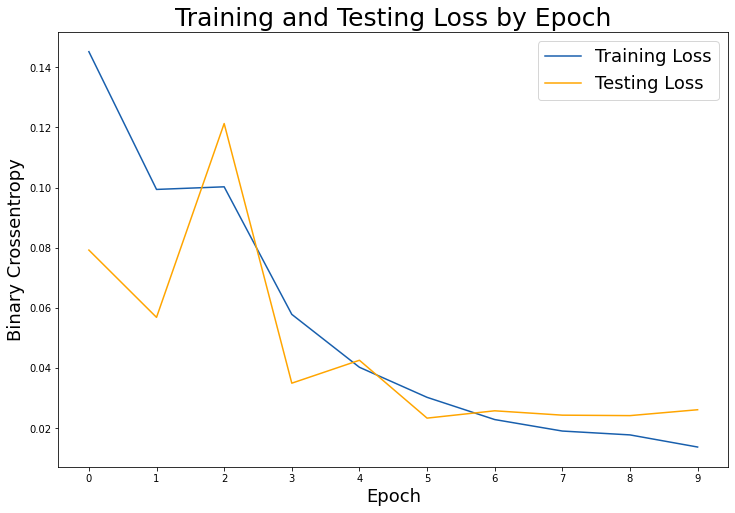

In [36]:
plot_graph(history)

In [37]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('./saved_model/lstm_cnn.h5')

## Making Predictions

In [38]:
def predict_sentiment(score):
    return 1 if score > 0.5 else 0
    
scores = model.predict(X_test_indices)


In [39]:
model_predictions = [predict_sentiment(score[0]) for score in scores]

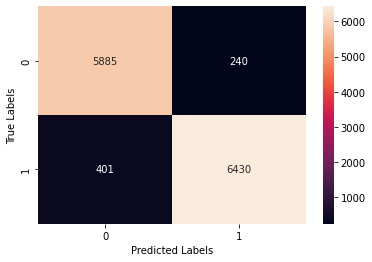

In [40]:
cm = confusion_matrix(np.array(y_test), model_predictions)
f = sns.heatmap(cm, annot=True, fmt='d')
f.set(xlabel='Predicted Labels', ylabel='True Labels');

In [41]:
# Classification report
print(classification_report(np.array(y_test), model_predictions))


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6125
           1       0.96      0.94      0.95      6831

    accuracy                           0.95     12956
   macro avg       0.95      0.95      0.95     12956
weighted avg       0.95      0.95      0.95     12956



In [42]:
# saved_model = tf.keras.models.load_model('/content/drive/MyDrive/lstm_cnn.h5')


### Checking level of depression of random texts for the model

In [43]:
# Reading in the data to be used for validation
valid_data = pd.read_csv('/content/drive/MyDrive/ValidationText.csv')
valid_data.head()

,#,Text,From,Source
0,1,Cut deeper,Tumblr: Depression & Disorders,Buzzfeed Article (https://www.buzzfeednews.com...
1,2,"Dear mom & dad, I'm sorry for failing you, I'm...",Tumblr: Depression & Disorders,Buzzfeed Article (https://www.buzzfeednews.com...
2,3,Confession: My therapist doesn't think my prob...,Tumblr: Depression & Disorders,Buzzfeed Article (https://www.buzzfeednews.com...
3,4,Depression is not something to be happy about....,Tumblr: Depression & Disorders,Buzzfeed Article (https://www.buzzfeednews.com...
4,5,I feel really bad tonight...Seriously thinking...,Tumblr: Depression & Disorders,Buzzfeed Article (https://www.buzzfeednews.com...


In [44]:
data = np.array(valid_data['Text'])
data

array(['Cut deeper',
       "Dear mom & dad, I'm sorry for failing you, I'm sorry for not being your dream daughter. I know you did your best and I know how much it hurt when you found out what I'm doing to myself. I'm sorry for letting you down.",
       "Confession: My therapist doesn't think my problems are serious and it's just a part of being a teenager. Little does she know, how much I want to die. Not just kind of...I really want, And I will.",
       "Depression is not something to be happy about. I hate the fact that everything I just said, is only a quarter of what I feel. Some people get excited when they're diagnosed with depression. 'Oh I'm going to tell my friends, maybe I'll get some sympathy .' No you stupid c***. It is the worst thing, that's why, when I was diagnosed with depression. I felt crazy. Because I'm not normal. I'm depressed, and pain lives in me, and I can't escape it. That's the sad thing. No one takes it seriously.",
       'I feel really bad tonight...Se

In [49]:
indices = tokenizer.texts_to_sequences(data[7])
padded_text = pad_sequences(indices, maxlen=max_len, padding='post')
model.predict(padded_text)[0][0]

array([0.99936134], dtype=float32)

In [50]:
indices = tokenizer.texts_to_sequences('Happiness is when what you thin, what you say and what you do are in Harmony.')
padded_text = pad_sequences(indices, maxlen=max_len, padding='post')
model.predict(padded_text)[0][0]

array([0.3463966], dtype=float32)